In [1]:
# import dask.config as dc
import dask.array as da
import numpy as np
import rioxarray
import xarray as xr
import glob
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import pandas as pd
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

!!!
convert era5land from [0,360] to [-180,180], resample SSM in [-180,180], then convert resampled SSM from [-180,180] to [0,360]. There is a werid line after convert the resampled SSM.

# SSM data: from NetCDF to Zarr

The Surface Soil moisture (SSM) dataset is provided as geotiff data. We reproject the spatial extend to match the ERA5 land dataset using rioxarray, which, unfortunately does not support Dask. It was reprojected and downloaded from GEE. It is only for Europe, need to download other area from GEE.

## Input variables

In [2]:
year = 2015

In [3]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
SSM_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm/'
)
OUT_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm'
)

In [4]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [21]:
ds = xr.open_zarr(ERA5_PATH)

In [30]:
ds = ds.rio.write_crs('WGS84')
target0 = ds['sp'].isel(time=0, drop=True)

In [66]:
# convert from [0,360] to [-180,180]
target0['longitude'] = (target0['longitude'] + 180) % 360 - 180
target0 = target0.sortby('longitude')

select Europe area

In [32]:
import geopandas as gpd
from shapely.geometry import box

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/input_data/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [35]:
target = target0.sel(
    latitude=slice(bbox[3], bbox[1]),  
    longitude=slice(bbox[0], bbox[2])  
)

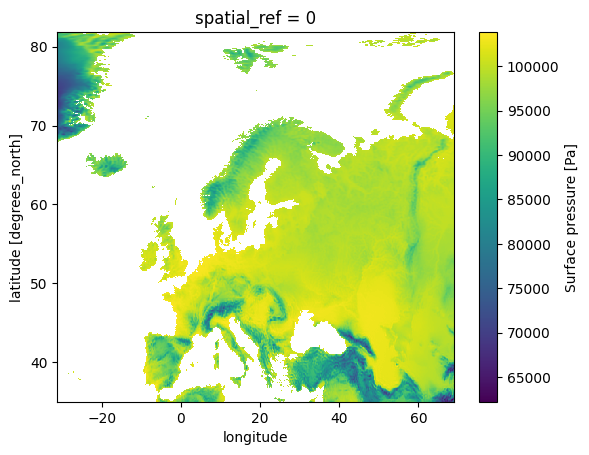

In [37]:
target.plot() # why it looks so weird? but the reprojected ssm seems okay

We now open the SSM geotiff files. NOTE: we do not set chunks in the spatial dimension because we need to load all values anyway to perform the reprojection. 

In [53]:
ssm_paths = sorted(
    glob.glob(f'{SSM_DIR}/*2015*Europe*Europe*.tif')
)

In [54]:
ssm_paths

['/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/SM2015Europe11kmEurope20230921.tif']

In [55]:
ssm = xr.open_dataset(ssm_paths[0])
ssm = ssm['band_data']
# ssm = ssm.sel(x=slice(20,25), y=slice(65, 60))

In [56]:
ssm

<xarray.DataArray 'band_data' (band: 365, y: 470, x: 1003)>
[172064650 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * x            (x) float64 -31.25 -31.15 -31.05 -30.95 ... 68.75 68.85 68.95
  * y            (y) float64 81.85 81.75 81.65 81.55 ... 35.25 35.15 35.05 34.95
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area

We fix the longitude ordering and make sure the CRS is in place:

In [57]:
ssm = ssm.rio.write_crs('WGS84')
ssm = ssm.rename(
    x='longitude',
    y='latitude',
)

We change band to time, and reproject!

In [58]:
ssm['band'] = pd.to_datetime(ssm.band-1, unit='D', origin=str(ssm_paths[0].split('/')[-1][2:6]))
ssm = ssm.rename({'band':'time'})
ssm = ssm[0:2,:] # test for short periods

In [59]:
ssm.rio.write_nodata(np.nan, inplace=True)
ssm = ssm.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
# ssm.rio.write_nodata(ssm.rio.nodata, inplace=True)
ssm_reprojected = ssm.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan) #
ssm_reprojected = ssm_reprojected.rename(
    x='longitude',
    y='latitude',
)
ssm_reprojected.isnull().sum()

<xarray.DataArray 'band_data' ()>
array(655796)
Coordinates:
    spatial_ref  int64 0

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


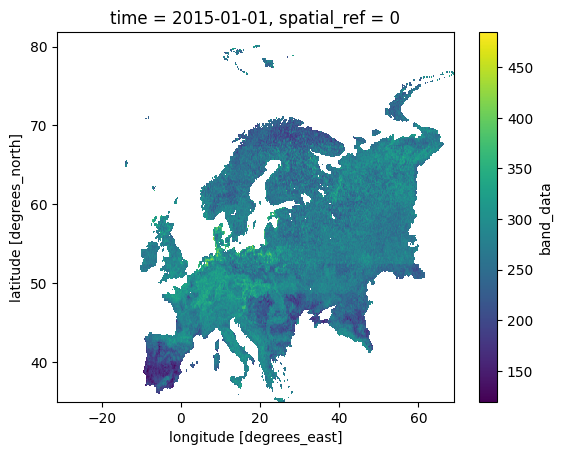

In [60]:
ssm_reprojected[0].plot()

In [61]:
ssm_reprojected = ssm_reprojected.assign_coords(
    longitude=(ssm_reprojected.longitude + 360) % 360,
    latitude=ssm_reprojected.latitude
)#.sortby('longitude')
# roll array to reorder coordinates 
nroll = (ssm_reprojected.longitude.values >= 180 ).sum()
ssm_reprojected = ssm_reprojected.roll(longitude=-nroll, roll_coords=True)

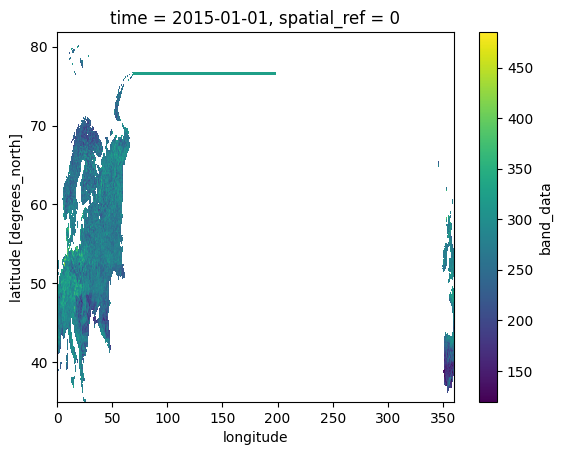

In [62]:
ssm_reprojected[0].plot()

In [63]:
ssm_reprojected.isnull().sum()

<xarray.DataArray 'band_data' ()>
array(655796)
Coordinates:
    spatial_ref  int64 0

In [64]:
ssm_reprojected[0].mean()

<xarray.DataArray 'band_data' ()>
array(268.36057, dtype=float32)
Coordinates:
    time         datetime64[ns] 2015-01-01
    spatial_ref  int64 0

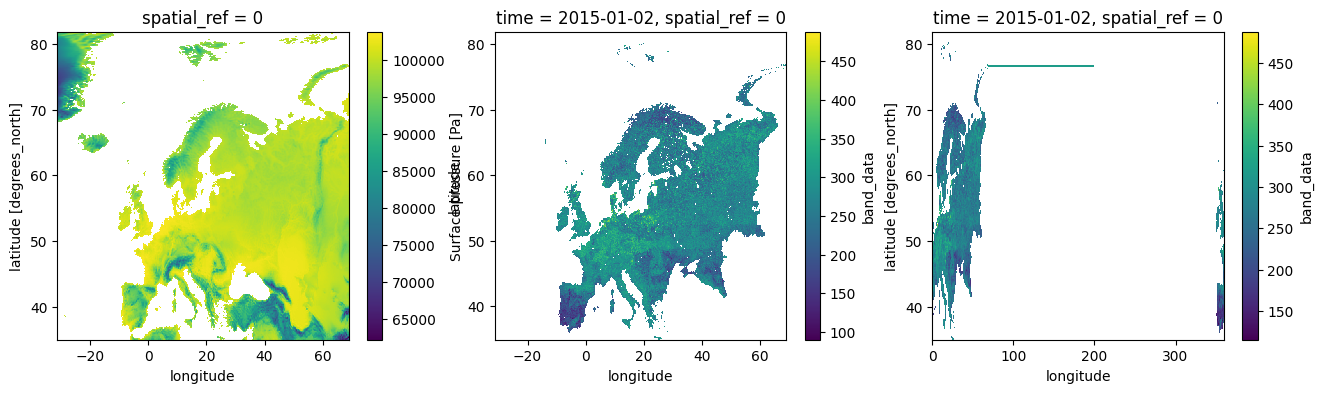

In [65]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
ssm[-1,::].plot(ax=axes[1])
ssm_reprojected[-1,::].plot(ax=axes[2])
plt.draw()

We rechunk and save it as Zarr:

In [26]:
ssm_reprojected = ssm_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
ssm_reprojected = ssm_reprojected.to_dataset(name='SSM')

In [27]:
%%time
zarr_path = f'{OUT_DIR}/ssm.zarr'
ssm_reprojected.to_zarr(zarr_path, mode='w')

CPU times: user 22.6 ms, sys: 9.6 ms, total: 32.2 ms
Wall time: 174 ms


When done with the conversion we switch off the cluster to release resources:

In [89]:
!du -h $zarr_path

2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/spatial_ref
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/latitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/time
1.5K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/SSM
11K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr
